# Tests JSA calculation class

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import savemat
from matplotlib.ticker import MaxNLocator

from topdc_calc import topdc_calc

#### Import the dispersion parameters

In [2]:
#Dispersion import 

dispdata=np.load('disp_data.npy',allow_pickle=True).item()
omf=dispdata['omf']
triplet_neff=dispdata['triplet_neff']
omp=dispdata['omp']
pump_neff=dispdata['pump_neff']
wp_cutoff=9.8  #Pump mode cutoff frequency in 10^14 rad/s

test=topdc_calc(omf,triplet_neff,omp,pump_neff,wp_cutoff)

In [3]:
# Declaration of variables

c0=3 # Velocity of light in vacuum in um/(1e-14 s)
L=300000 # Waveguide length in um ->10000 um=1 cm

wf0=test.w_pm(13)   # Triplet phase-matching frequency in 10^14 rad/s (The input parameter 13  is the initial guess for the triplet central frequency--> You can check this by plotting the dispersion of the pump and triplet modes) 
wp0=3*wf0   # Pump phase-matching frequency in 10^14 rad/s 

In [4]:
print('Triplet central frequency: '+str(wf0)+' [x10^14 rad/s]')
print('Triplet central wavelength: '+str(2*np.pi*c0/wf0)+' um')
print('Pump central frequency: '+str(wp0)+' [x10^14 rad/s]')
print('Pump central wavelength: '+str(2*np.pi*c0/wp0)+' um')

Triplet central frequency: 13.696149605647763 [x10^14 rad/s]
Triplet central wavelength: 1.3762667949951373 um
Pump central frequency: 41.08844881694329 [x10^14 rad/s]
Pump central wavelength: 0.45875559833171237 um


In [5]:
#Evaluation of the JSA

# Spectral resolution
sigmap=test.pm_bw(L,13) #Half-width (at 1/e-pump intensity point) matching approximately the width of the phase-matching function, measured in terms of the sinc's main lobe width
delw=sigmap/60 # The spectral resolution is defined such that a minimum of 60 discrete points are sampled within each frequency vector over the bandwidth of the phase-matching function, regardless of the specific width of the evaluation function.

#Spectral window
domg=8*sigmap # We set the half-width of the frequency window wide enough to sample correctly both the jsa and reduced density matrix
omf1=np.arange(wf0-domg,wf0+domg,delw) # Frequency evaluation vector centered at the photon triplet phase-matching frequency with units 10^14 rad/s
print(omf1.size) # Note: Always check the frequency vector size, because later we are going to build a 3D grid with it, which greatly affects the memory usage. 

960


We are going to filter outside the frequencies $[11.5,15]\times~10^{14}$ rad/s.

In [6]:
wlow=11.5 # Filter lower limit
whigh=15  # Filter higher limit
print(test.rho_filter(wf0,wf0,wf0,L,wp0,sigmap,wlow,whigh).jsa) # Checking that the jsa is 1 at the triplet phase-matching frequency
jsa_data=test.rho_filter(omf1[:,None,None],omf1[None,:,None],omf1[None,None,:],L,wp0,sigmap,wlow,whigh)  # Evaluation of the jsa calculation function

1.0


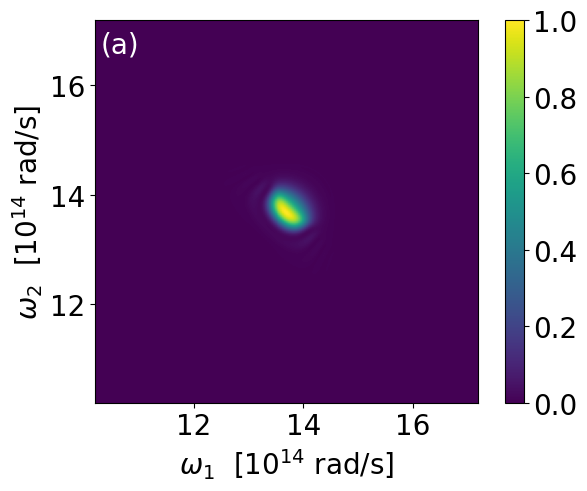

In [7]:
font={'size':20}
plt.rc('font',**font)

fig1, axs1 = plt.subplots(1, 1, sharex=True, sharey=True, constrained_layout=True)

c1=axs1.pcolor(omf1,omf1, jsa_data.jsa_proj/np.max(jsa_data.jsa_proj), rasterized=True)

axs1.set_box_aspect(1)
axs1.set_xlabel(r'$\omega_{1}$  [$10^{14} $ rad/s]')
axs1.set_ylabel(r'$\omega_{2}$  [$10^{14} $ rad/s]')
fig1.colorbar(c1)

fig1.text(0.25,0.9, '(a)',color='white')
plt.gca().set_aspect('equal')

# Automatically set ticks using MaxNLocator
axs1.xaxis.set_major_locator(MaxNLocator(integer=True,nbins=6))  # For x-axis
axs1.yaxis.set_major_locator(MaxNLocator(integer=True,nbins=6))  # For y-axis

# Get current ticks
x_ticks = axs1.get_xticks()
y_ticks = axs1.get_yticks()

# Remove the first and last ticks
axs1.set_xticks(x_ticks[1:-1])
axs1.set_yticks(y_ticks[1:-1])

plt.show()

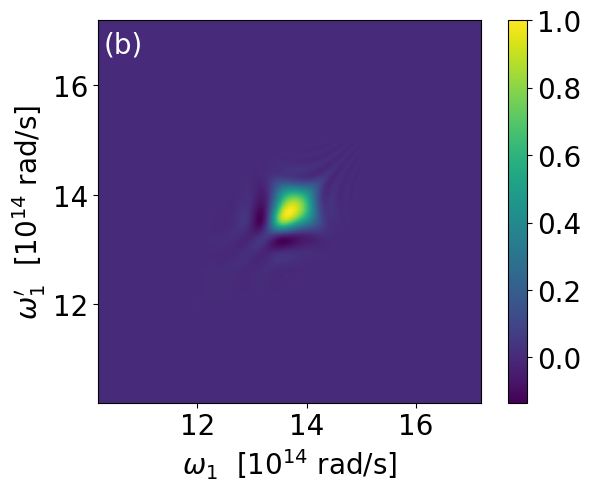

In [8]:
font={'size':20}
plt.rc('font',**font)

figr1, axsr1 = plt.subplots(1, 1, sharex=True, sharey=True, constrained_layout=True)

cr1=axsr1.pcolor(omf1,omf1, jsa_data.density_matrix/np.max(jsa_data.density_matrix))

axsr1.set_box_aspect(1)
axsr1.set_xlabel(r'$\omega_{1}$  [$10^{14} $ rad/s]')
axsr1.set_ylabel(r"$\omega_{1}'$  [$10^{14} $ rad/s]")

figr1.colorbar(cr1)
figr1.set_edgecolor('none')
figr1.text(0.25,0.9, '(b)',color='white')
plt.gca().set_aspect('equal')

# Automatically set ticks using MaxNLocator
axsr1.xaxis.set_major_locator(MaxNLocator(integer=True,nbins=6))  # For x-axis
axsr1.yaxis.set_major_locator(MaxNLocator(integer=True,nbins=6))  # For y-axis

# Get current ticks
x_ticks = axsr1.get_xticks()
y_ticks = axsr1.get_yticks()

# Remove the first and last ticks
axsr1.set_xticks(x_ticks[1:-1])
axsr1.set_yticks(y_ticks[1:-1])

plt.show()

In [9]:
print(jsa_data.purity)

1.5028324780554752


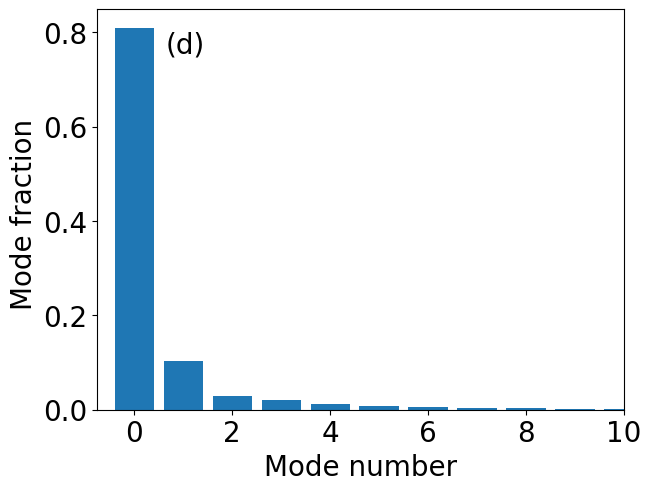

In [10]:
font={'size':20}
plt.rc('font',**font)

figm, axsm = plt.subplots(1, 1, sharex=True, sharey=True, constrained_layout=True)

x=np.arange(0,len(jsa_data.eigen_values))
plt.bar(x,jsa_data.eigen_values/np.sum(jsa_data.eigen_values))

plt.xlabel(r'Mode number', fontsize = 20)
plt.ylabel(r'Mode fraction ', fontsize = 20)

figm.text(0.25,0.9, '(d)',color='black')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(-0.75,10)

plt.show()

In [11]:
Sn=jsa_data.eigen_values/np.sum(jsa_data.eigen_values) # Normalized eigenvalues
Un=jsa_data.eigen_modes/abs(jsa_data.eigen_modes).max(axis=0) # Normalized eigenmodes

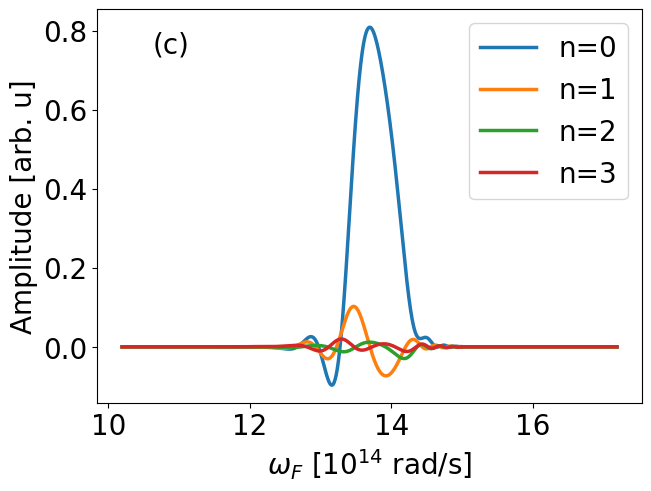

In [12]:
font={'size':20}
plt.rc('font',**font)
figv, axsv = plt.subplots(1, 1, sharex=True, sharey=True, constrained_layout=True)

plt.plot(omf1,-1*Sn[0]*Un[:,0], label='n=0',linewidth=2.5)
plt.plot(omf1,Sn[1]*Un[:,1], label='n=1',linewidth=2.5)
plt.plot(omf1,Sn[2]*Un[:,2], label='n=2',linewidth=2.5)
plt.plot(omf1,Sn[3]*Un[:,3], label='n=3',linewidth=2.5)
plt.xlabel(r"$\omega_F$ [$10^{14} $ rad/s]") 
plt.ylabel("Amplitude [arb. u]") 
figv.text(0.23,0.9, '(c)',color='black')
plt.legend()  

plt.show()

#### Triplet photon rate

In [13]:
# Pump pulse duration of the intensity envelope
tau=np.sqrt(4*np.log(2))/sigmap  # FWHM pulse duration Units: 10^-14 seg
print('Pump pulse duration: '+str(tau*10)+' fs.')

Pump pulse duration: 38.07479072799993 fs.


In [14]:
# Nonlinear parameter
gammafff=1.19e5 #Nonlinear parameter in units [10^-14 s / um J] (For its calculation, see notebook nonlinear_parameter.ipynb)
hbar=1.054571817e-20 # Reduced Planck constant in units [J*10^-14s]
pavg=0.4 #Average pump power per pulse in Watt
jsa_vol=np.sum(jsa_data.jsa**2)*(omf1[1]-omf1[0])**3
# Triplet photon rate
Rfff=(1/(6*np.pi**2))*((gammafff*L)**2)*((hbar*wf0)**2)*(pavg/(hbar*wp0))*(1/(np.sqrt(np.pi)*sigmap))*jsa_vol
print('Triplet rate: '+str(Rfff)+' Hz')

Triplet rate: 0.10450848311068701 Hz


#### Data export

In [15]:
freq=np.linspace(10,16,100)
difn=[test.neff_p(3*x)-test.neff_f(x) for x in freq]
difvg=[test.vg_p(3*x)-test.vg_f(x) for x in freq]

In [16]:
dispdict={
    "tag":"36GeO2_rco_849nm_rcl_2340p86nm",
    "omp":omp,
    "pump_neff":test.neff_p(omp),
    "omf":omf,
    "triplet_neff":test.neff_f(omf),
    "pump_vg":test.vg_p(omp),
    "triplet_vg":test.vg_f(omf),
    "freq":freq,
    "difn":difn,
    "difvg":difvg,
    "delk":test.delk0(omf)
}
# savemat("Data_export/36GeO2_rco_849nm_rcl_2340p86nm_dispersion.mat",dispdict)

In [17]:
jsidict={
    "tag":"36GeO2_rco_849nm_rcl_2340p86nm",
    "omf":omf1,
    "jsi_proj":jsa_data.jsa_proj
}

# savemat("Data_export/36GeO2_rco_849nm_rcl_2340p86nm_jsi_proj.mat",jsidict)

In [18]:
rhodict={
    "tag":"36GeO2_rco_849nm_rcl_2340p86nm",
    "omf":omf1,
    "rho":jsa_data.density_matrix
}
# savemat("Data_export/36GeO2_rco_849nm_rcl_2340p86nm_rho.mat",rhodict)

In [19]:
eigendict={
    "tag":"36GeO2_rco_849nm_rcl_2340p86nm",
    "snumbers":jsa_data.eigen_values,
    "smodes":jsa_data.eigen_modes
}
# savemat("Data_export/36GeO2_rco_849nm_rcl_2340p86nm_eigendecomposition.mat",eigendict)